Calculate the optimal pitch angle for the lidar to get the shortest distance between the horizontal lines thrown onto the ground / ramp

In [32]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go#
import pandas as pd
import math

In [33]:
def calc_lidar_hitpoints(lidar_height=1, dist_to_ramp=10, ramp_angle=7, lidar='robos'):
    """Calculate where each laser line of lidar hits the ground/ramp"""
    # Car/Lidar height [m]
    h = lidar_height
    # Distance to ramp [m]
    z = dist_to_ramp
    # Ramp angle [rad]
    epsilon = np.deg2rad(ramp_angle)

    # Lidar vertical line angles [rad]
    if lidar == 'robos':
        # 32 channels and max angle of 90, resolution of 2.81
        lidar_angles = np.deg2rad(np.linspace(2.81, 90, 32))
    elif lidar == 'velodyne':
        # 32 channels and FOV from -25 to 15, resolution of 0.33
        #! Linear distribution is a wrong assumption, it is not linear
        lidar_angles = np.deg2rad(np.linspace(-25, 15, 32))
    # Lidar mount pitch angles [rad]
    pitch_angles = np.deg2rad(np.linspace(1, 90, 90))

    # Calculate important things
    dic = []
    # Try different mount pitch angles of LiDAR
    for alpha in pitch_angles:
        # Take all different laser lines of LiDAR into account
        for rho in lidar_angles:
            # x distance where light would hit if ground is flat
            x_dist = h / np.tan(alpha - rho)

            # Light travels far enough to hit ramp, flat ground assumption is not true anymore
            if x_dist > z:
                # y height at which laser beam is, when ramp starts [m]
                y_ramp_start = h - z / np.tan(90-alpha+rho)

                # Some helper angles
                beta = math.pi/2 - epsilon
                gamma = math.pi - alpha - beta

                # x distance on ramp (not true x, slightly tilted) where light hits the ramp
                x_dist_ramp = y_ramp_start * np.sin(math.pi/4 - alpha + rho) / np.sin(gamma)
                # Height above flat ground where laser hits ramp
                y_hit = np.sin(epsilon) * x_dist_ramp 
                # Length from start of ramp of on flat ground where laser hits
                x_hit = np.sqrt(x_dist_ramp**2 - y_hit**2)
                # x distance from lidar to hit on ramp
                x_dist_cor = x_hit + z

            # No special assumptions have to be made, light hits ground (or nothing)
            else:
                x_dist_cor = x_dist
                # y does not change if ground is hit
                y_hit = 0

            # Add information about hitpoint (x,y) and parameters for each step to dic
            dic.append({
                "ang_mount": alpha,
                "ang_line": rho,
                "x_hit": x_dist,
                "x_hit_cor": x_dist_cor, 
                "y_hit": y_hit, 
                # Information for the plot
                "height": h, 
                "ramp_dist": z, 
                "ang_ramp": epsilon})
    # Convert to pandas dataframe
    df = pd.DataFrame(dic)
    # Reorder columns
    df = df[['ang_mount', 'ang_line', 'x_hit', 'x_hit_cor', 'y_hit', 
        'height', 'ramp_dist', 'ang_ramp']]
    return df

In [37]:
def create_nice_fig(df):
    """Display the thrown lidar points in an xy diagram"""
    # Extract constants from df
    # Ramp angle
    epsilon = df['ang_ramp'][0]
    # Distance to ramp
    z = df['ramp_dist'][0]
    # Extract all lidar mount pitch angles
    pitch_angles = df['ang_mount'].unique()

    fig = go.Figure()
    # Add traces, one for each slider step
    # Each step is a change of LiDAR mount pitch angle
    for ang_mount in pitch_angles:
        # Extract data for specific mount_angle
        df_select = df[df['ang_mount'] == ang_mount]
        fig.add_trace(
            go.Scatter(
                visible=False, mode='markers',
                x=df_select['x_hit_cor'], y=df_select['y_hit'],
                # text = '{:.2f}°'.format([x for x in df_select['ang_line']]),
                text = ['{:.2f}°'.format(np.rad2deg(x)) for x in df_select['ang_line']],
                # Show information when hovering over point
                hovertemplate = 
                    'x: %{x:.2f}, y: %{y:.2f}<extra></extra>' +
                    '<br>Channel ang: %{text}<br>'
            )
        )
    fig.data[0].visible = True

    # Set static axes limits
    fig.update_xaxes(range = [-5, 40])

    # Length of ramp to visualize
    ramp_x = 25
    # Height of ramp at end (for plot)
    ramp_y = np.tan(epsilon) * ramp_x
    # Add line to show ramp
    fig.add_shape(type="line",
        x0=z, y0=0, x1=z+ramp_x, y1=ramp_y,
        line=dict(color="MediumPurple", width=1))
    # Add line to show ground
    fig.add_shape(type="line",
        x0=0, y0=0, x1=z, y1=0,
        line=dict(color="MediumPurple", width=1))
    # Add image of a LiDAR (very important!)
    # Get lidar type by looking at max open angle (90deg means robosense)
    lidar = 'robos' if df['ang_line'].iloc[-1] == math.pi/2 else 'velodyne'
    if lidar == 'robos':
        src_img = "https://cdn.robosense.cn/20210408171744_32513"
    elif lidar == 'velodyne':
        src_img = "https://eak2mvmpt4a.exactdn.com/wp-content/uploads/2019/08/Velodyne_Ultrapuck.png?strip=all&lossy=1&ssl=1&fit=396,396"
    fig.add_layout_image(
        dict(
            source=src_img,
            xref="x", yref="y", x=-0.5, y=1.2,
            sizex=1, sizey=2, opacity=0.8))

    # Create and add slider
    steps = []
    for i,v in enumerate(pitch_angles):
        # Extract data for specific mount_angle
        df_select = df[df['ang_mount'] == v]

        # Calculate some info to display in title for each step
        # Number of points which do not hit the ground/ramp
        hits = len(df_select[df_select['x_hit'] < 0])
        # Percentage of points which do not hit the ground
        hits_ratio = hits/float(len(df_select))
        # Number of points which hit the ramp
        hits_ramp = len(df_select[df_select['x_hit'] > 10])
        # How many lines are thrown in desired region
        region = [5, 10]
        hit_region_count = len(df_select[(df_select['x_hit'] > region[0]) & 
            (df_select['x_hit'] < region[1])]['x_hit'])

        # Add title and data points for each step to slider
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                {"title": 'Lidar mount pitch angle of {:.0f}°<br>{:.2f}% of points are wasted (do not hit the ground)<br>\
{} lines are thrown in region before ramp (5 to 10 m) and {} onto ramp'.format(
                    np.rad2deg(pitch_angles)[i], hits_ratio*100, hit_region_count, hits_ramp)}],
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)
    # Create slider
    sliders = [dict(
        active=0,
        # currentvalue={"prefix": "Detected plane: "},
        steps=steps)]
    fig.update_layout(sliders=sliders, xaxis_title='x [m]', yaxis_title='y [m]', 
        hovermode='x unified')
    fig.show()

/home/user/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning:

divide by zero encountered in double_scalars



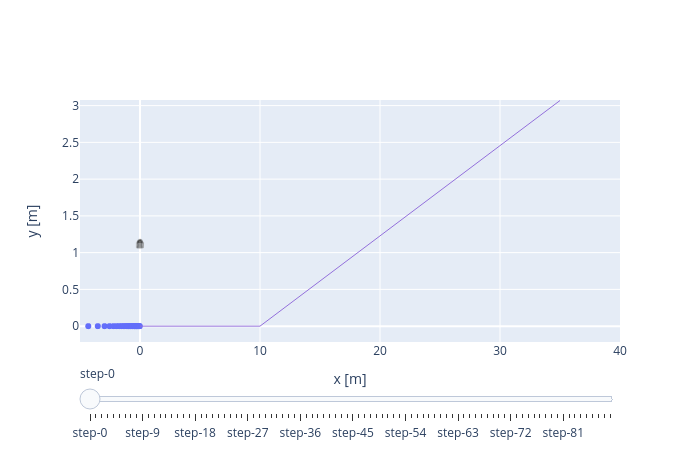

In [38]:
df = calc_lidar_hitpoints()
create_nice_fig(df)

In [36]:
df = calc_lidar_hitpoints(lidar='velodyne')
create_nice_fig(df)

/home/user/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning:

divide by zero encountered in double_scalars

